# Facial Emotion Recognition Using Machine Learning Methods

In [1]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input, decode_predictions
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

ModuleNotFoundError: No module named 'sklearn'

## Data Preprocessing

In [2]:
DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [3]:
def load_data():
    data = []
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
    return data

data = load_data()

100%|██████████| 135/135 [00:00<00:00, 343.81it/s]


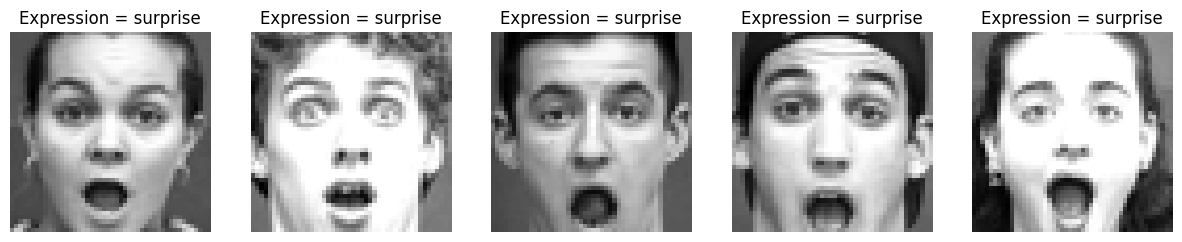

In [4]:
samples = data[0:5]

fig, axes = plt.subplots(1, len(samples), figsize=(15,5))

for i, sample in enumerate(samples):
    img = sample[0]      
    label = sample[1]   
    axes[i].set_title("Expression = " + str(CATEGORIES[label]))
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')

plt.show()

In [5]:
import os
import cv2
import numpy as np
import random
from tqdm import tqdm
from skimage.feature import hog
import dlib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


DATADIR = r'/kaggle/input/ck-dataset'
CATEGORIES = os.listdir(DATADIR)
IMG_SIZE = 64  

# -------------------------------
# Thiết lập face detector và predictor (cho face alignment)
# -------------------------------
predictor_path = "/kaggle/input/shape-predictor-68-face-landmarks/shape_predictor_68_face_landmarks.dat"
if os.path.exists(predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)
    use_alignment = True
    print("Face alignment sẽ được sử dụng.")
else:
    print("Warning: Không tìm thấy file shape_predictor_68_face_landmarks.dat. Bỏ qua face alignment.")
    use_alignment = False

def enhance_image(img):
    """
    Histogram equalization là một kỹ thuật xử lý ảnh nhằm cải thiện độ tương phản bằng cách phân bố lại 
    các giá trị pixel sao cho histogram của ảnh được trải đều hơn. Kỹ thuật này giúp làm nổi bật các chi tiết 
    quan trọng trong ảnh, đặc biệt hữu ích khi ảnh có các vùng quá tối hoặc quá sáng.

    Steps:
        1. Nhận ảnh đầu vào dạng grayscale dưới dạng mảng NumPy.
        2. Sử dụng cv2.equalizeHist để áp dụng histogram equalization.
        3. Trả về ảnh sau khi được tăng cường.

    Parameters:
        img (numpy.ndarray): Ảnh đầu vào ở dạng grayscale (mảng 2 chiều).

    Returns:
        numpy.ndarray: Ảnh đã được xử lý, với độ tương phản được cải thiện.
    """
    return cv2.equalizeHist(img)

def align_face(img):
    """
    Thực hiện canh chỉnh khuôn mặt trong ảnh bằng cách sử dụng thư viện dlib.

    Quy trình:
        1. Phát hiện khuôn mặt trong ảnh sử dụng detector của dlib.
        2. Nếu có khuôn mặt, dự đoán 68 điểm landmark của khuôn mặt đó.
        3. Tính vị trí trung bình của mắt trái và mắt phải từ các landmark tương ứng.
        4. Tính góc giữa đường nối hai mắt và xoay ảnh sao cho đường nối này nằm ngang.
        5. Trả về ảnh đã được xoay (canh chỉnh).
        6. Nếu không phát hiện được khuôn mặt, trả về ảnh gốc.

    Parameters:
        img (numpy.ndarray): Ảnh đầu vào dạng grayscale.

    Returns:
        numpy.ndarray: Ảnh đã được canh chỉnh (nếu khuôn mặt được phát hiện) hoặc ảnh gốc nếu không thể canh chỉnh.
    """
    rects = detector(img, 1)
    if len(rects) == 0:
        return img
    rect = rects[0]
    shape = predictor(img, rect)
    landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    left_eye_pts = landmarks[36:42]
    right_eye_pts = landmarks[42:48]
    left_eye_center = left_eye_pts.mean(axis=0).astype(int)
    right_eye_center = right_eye_pts.mean(axis=0).astype(int)
    eyes_center = (int((left_eye_center[0] + right_eye_center[0]) / 2),
                   int((left_eye_center[1] + right_eye_center[1]) / 2))
    dY = right_eye_center[1] - left_eye_center[1]
    dX = right_eye_center[0] - left_eye_center[0]
    angle = np.degrees(np.arctan2(dY, dX))
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1)
    aligned_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_CUBIC)
    return aligned_img

def preprocess_image(img_path):
    """
    Thực hiện tiền xử lý cho ảnh dựa trên đường dẫn đến ảnh.

    Quy trình tiền xử lý bao gồm:
        1. Đọc ảnh ở dạng grayscale.
        2. Tăng cường ảnh bằng histogram equalization.
        3. Nếu được thiết lập sử dụng face alignment, canh chỉnh khuôn mặt.
        4. Resize ảnh về kích thước chuẩn (ví dụ: 64x64).

    Parameters:
        img_path (str): Đường dẫn đến ảnh.

    Returns:
        numpy.ndarray: Ảnh đã được tiền xử lý.
                        Nếu không đọc được ảnh, trả về None.
    """
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    enhanced = enhance_image(img)
    if use_alignment:
        aligned = align_face(enhanced)
    else:
        aligned = enhanced
    resized = cv2.resize(aligned, (IMG_SIZE, IMG_SIZE))
    return resized

def load_data():
    data = []
    labels = []
    for cat in CATEGORIES:
        path = os.path.join(DATADIR, cat)
        label = CATEGORIES.index(cat)
        for file in tqdm(os.listdir(path), desc=f"Processing {cat}"):
            img_path = os.path.join(path, file)
            processed = preprocess_image(img_path)
            if processed is not None:
                data.append(processed)
                labels.append(label)
    return np.array(data), np.array(labels)

print("Loading và tiền xử lý dữ liệu...")
images, labels = load_data()

Face alignment sẽ được sử dụng.
Loading và tiền xử lý dữ liệu...


Processing anger: 100%|██████████| 135/135 [00:00<00:00, 148.50it/s]


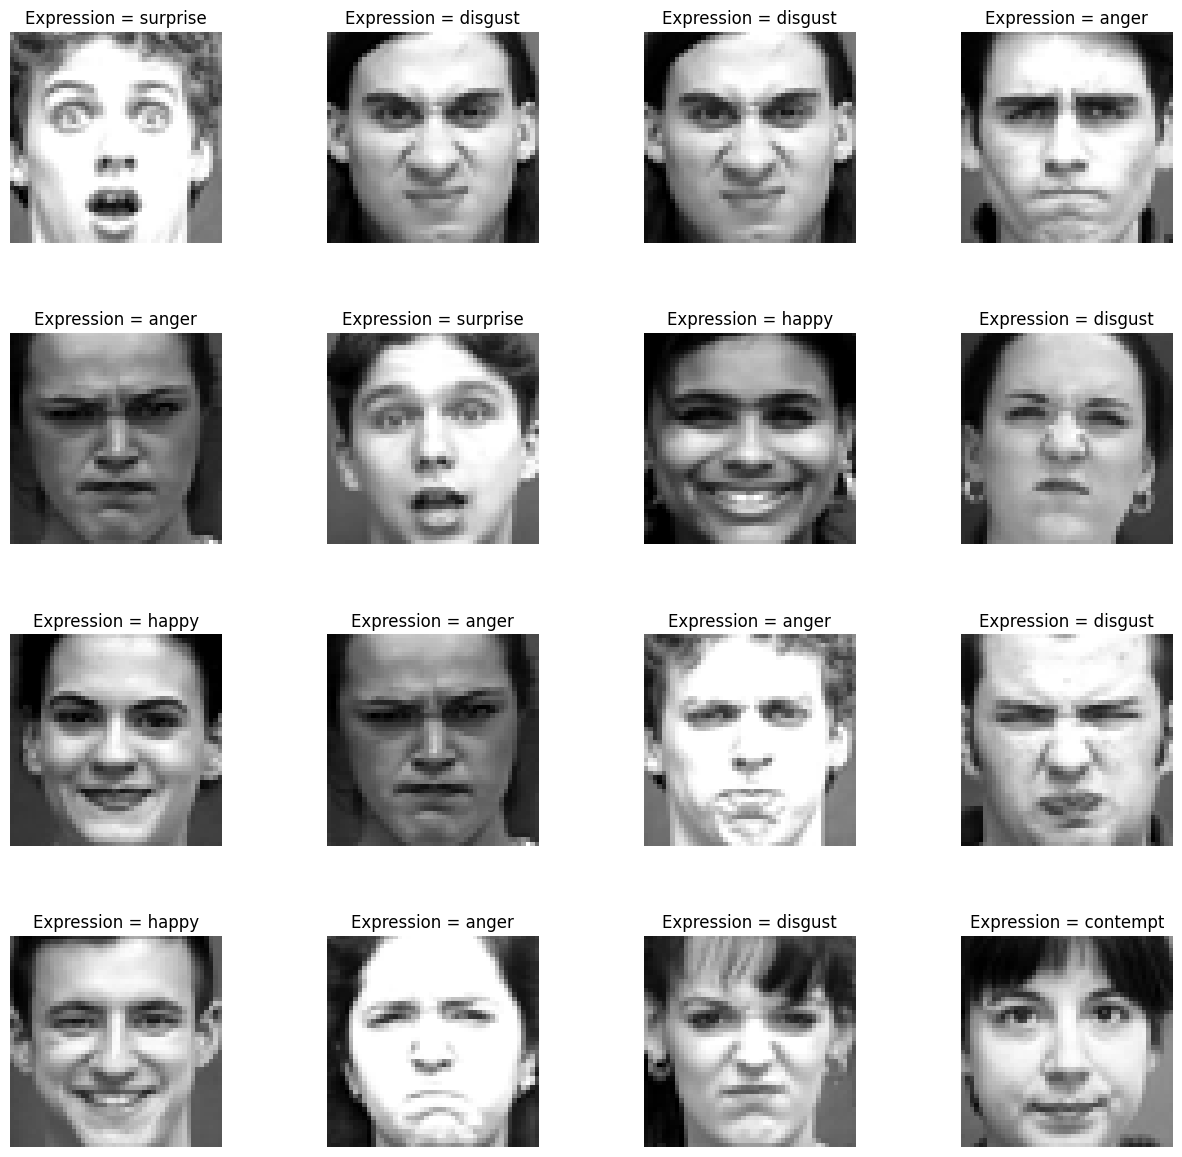

In [6]:
import matplotlib.pyplot as plt
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L*W):
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

## KNN

## KNN Code Hàm

In [7]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

def extract_hog_features(image):
    """
    Trích xuất đặc trưng HOG từ ảnh grayscale.
    
    Parameters:
        image (np.ndarray): Ảnh đầu vào dạng grayscale.
        
    Returns:
        np.ndarray: Vector đặc trưng HOG.
    """
    features = hog(image,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   transform_sqrt=True)
    return features

def extract_dct_features(image, keep_coeffs=8):
    """
    Trích xuất đặc trưng DCT từ ảnh.
    
    Quy trình:
      - Chuyển ảnh sang float32 và chuẩn hóa giá trị pixel về [0, 1].
      - Tính DCT của ảnh bằng hàm cv2.dct.
      - Lấy block góc trên bên trái có kích thước keep_coeffs x keep_coeffs.
      - Làm phẳng block thành vector đặc trưng.
    
    Parameters:
        image (np.ndarray): Ảnh đầu vào dạng grayscale.
        keep_coeffs (int): Số coefficient cần giữ trên mỗi chiều (mặc định 8, tức 8x8 = 64 đặc trưng).
        
    Returns:
        np.ndarray: Vector đặc trưng DCT.
    """
    img_float = np.float32(image) / 255.0
    dct = cv2.dct(img_float)
    dct_block = dct[:keep_coeffs, :keep_coeffs]
    return dct_block.flatten()

def extract_combined_features(images):
    """
    Với mỗi ảnh, trích xuất đặc trưng HOG và DCT sau đó nối (concatenate) chúng lại thành vector đặc trưng chung.
    
    Parameters:
        images (np.ndarray): Mảng các ảnh.
    
    Returns:
        np.ndarray: Ma trận đặc trưng với kích thước (số mẫu, số chiều HOG + 64).
    """
    hog_feats = [extract_hog_features(img) for img in tqdm(images, desc="Extracting HOG features")]
    dct_feats = [extract_dct_features(img, keep_coeffs=8) for img in tqdm(images, desc="Extracting DCT features")]
    hog_feats = np.array(hog_feats)
    dct_feats = np.array(dct_feats)
    combined = np.concatenate((hog_feats, dct_feats), axis=1)
    return combined

combined_features = extract_combined_features(images)
print("Số chiều ban đầu của vector đặc trưng kết hợp:", combined_features.shape[1])

Extracting DCT features: 100%|██████████| 981/981 [00:00<00:00, 18808.54it/s]


Số chiều ban đầu của vector đặc trưng kết hợp: 1828


Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


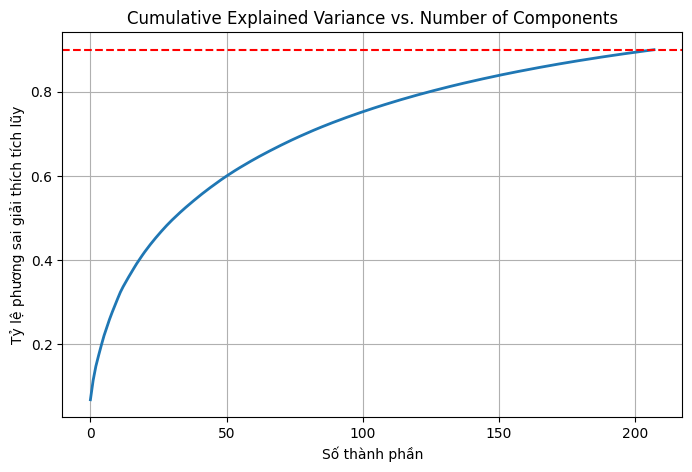

Best parameters cho KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9196553976808755
KNN Accuracy : 0.9847715736040609
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.88      1.00      0.93        14
       happy       1.00      1.00      1.00        42
       anger       0.96      1.00      0.98        23

    accuracy                           0.98       197
   macro avg       0.98      0.99      0.98       197
weighted avg       0.99      0.98      0.98       197



In [8]:
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA, 
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng nhất định.
    
    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95 nghĩa là 95%).
        
    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Mô hình PCA đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    # Sử dụng PCA để tự động chọn số thành phần sao cho đạt ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))

    import matplotlib.pyplot as plt
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler

features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)
# -------------------------------
# Chia dữ liệu thành tập huấn luyện và test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# -------------------------------
# Tối ưu hóa siêu tham số cho KNN bằng GridSearchCV
# -------------------------------
def grid_search_knn(X_train, y_train):
    """
    Sử dụng GridSearchCV để tìm các siêu tham số tối ưu cho KNN.
    
    Parameters:
        X_train (np.ndarray): Ma trận đặc trưng huấn luyện.
        y_train (np.ndarray): Nhãn huấn luyện.
        
    Returns:
        best_knn (estimator): Mô hình KNN với siêu tham số tối ưu.
        grid (GridSearchCV object): Đối tượng GridSearchCV đã được fit.
    """
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters cho KNN:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    
    best_knn = grid.best_estimator_
    return best_knn, grid

start_time = time.time()
best_knn, grid = grid_search_knn(X_train, y_train)
knn_train_time = time.time() - start_time


y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy :", acc_knn)
print("Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=CATEGORIES))





Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


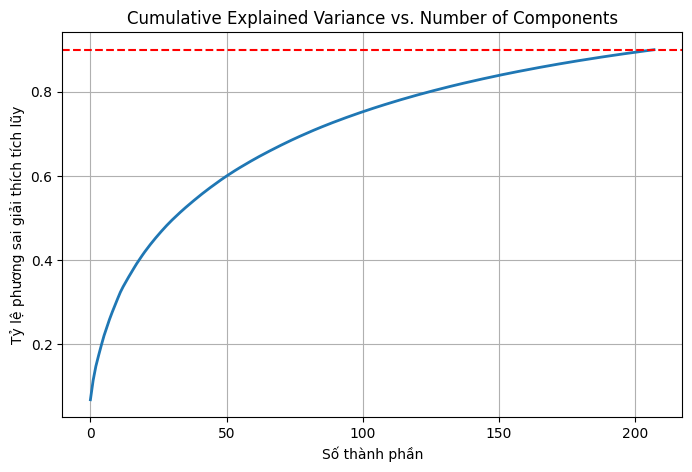

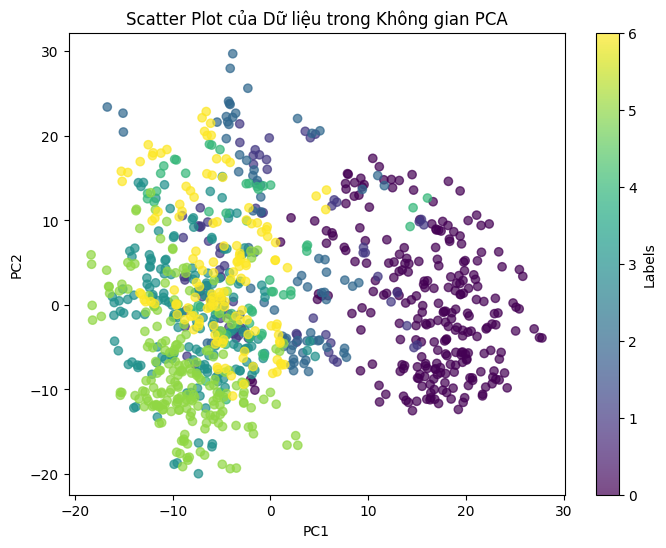

Best parameters cho KNN: {'n_neighbors': 1, 'weights': 'uniform'}
Best cross-validation accuracy: 0.9196553976808755
KNN Accuracy: 0.9847715736040609
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      0.92      0.96        37
    contempt       0.88      1.00      0.93        14
       happy       1.00      1.00      1.00        42
       anger       0.96      1.00      0.98        23

    accuracy                           0.98       197
   macro avg       0.98      0.99      0.98       197
weighted avg       0.99      0.98      0.98       197



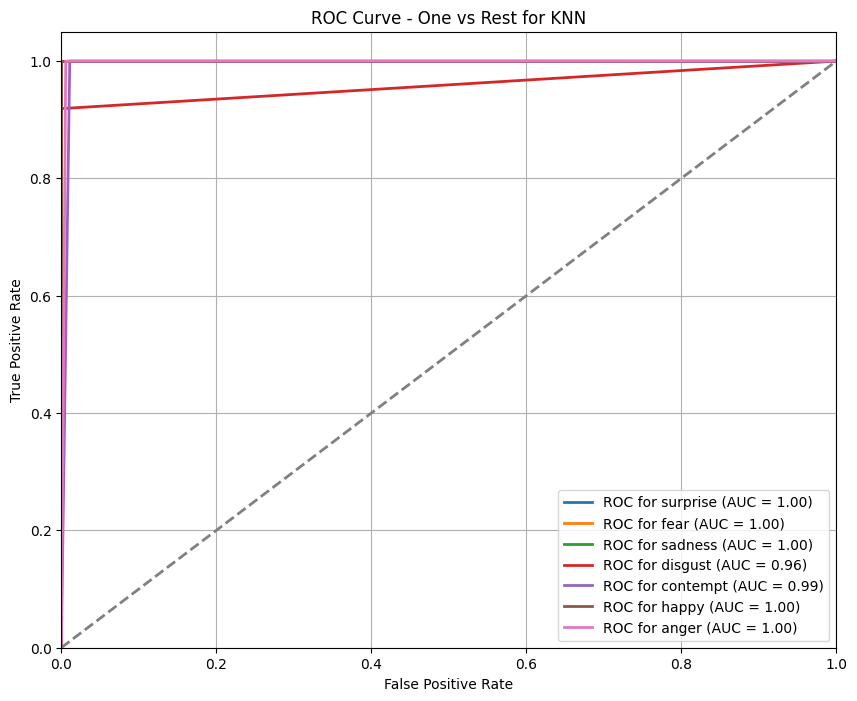

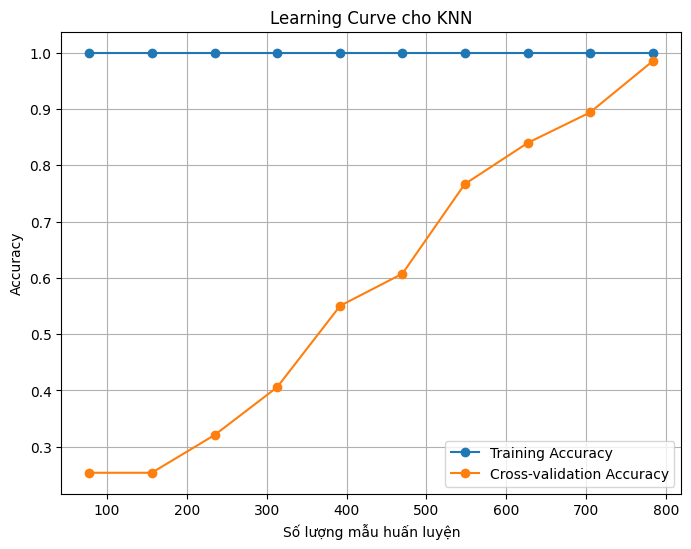

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#############################################
# 1. Hàm giảm chiều với PCA & Biểu đồ Cumulative Explained Variance
#############################################
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA, 
    tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng nhất định.

    Parameters:
        features (np.ndarray): Ma trận đặc trưng ban đầu.
        variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95 nghĩa là 95%).

    Returns:
        features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
        pca (PCA object): Mô hình PCA đã fit.
        scaler (StandardScaler): Bộ chuẩn hóa đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Sử dụng PCA để tự động chọn số thành phần sao cho đạt ngưỡng explained variance
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)

    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))

    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    return features_pca, pca, scaler

# Giảm chiều dữ liệu với threshold 0.9 (90% phương sai giải thích)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)

#############################################
# 2. Scatter Plot của dữ liệu trong không gian PCA
#############################################
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot của Dữ liệu trong Không gian PCA")
plt.colorbar(label="Labels")
plt.show()

#############################################
# 3. Tối ưu hóa siêu tham số cho KNN bằng GridSearchCV
#############################################
def grid_search_knn(X_train, y_train):
    """
    Sử dụng GridSearchCV để tìm các siêu tham số tối ưu cho KNN.
    
    Parameters:
        X_train (np.ndarray): Ma trận đặc trưng huấn luyện.
        y_train (np.ndarray): Nhãn huấn luyện.
        
    Returns:
        best_knn (estimator): Mô hình KNN với siêu tham số tối ưu.
        grid (GridSearchCV object): Đối tượng GridSearchCV đã được fit.
    """
    param_grid = {
        'n_neighbors': [1, 3, 5, 7, 9],
        'weights': ['uniform', 'distance']
    }
    knn = KNeighborsClassifier()
    grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best parameters cho KNN:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)

    best_knn = grid.best_estimator_
    return best_knn, grid

# Chia dữ liệu thành tập huấn luyện và test
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Tìm siêu tham số tối ưu cho KNN
best_knn, grid = grid_search_knn(X_train, y_train)

#############################################
# 4. Đánh giá mô hình KNN trên tập test
#############################################
y_pred = best_knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("KNN Accuracy:", acc)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=CATEGORIES))


#############################################
# 6. ROC Curve theo One-vs-Rest cho KNN
#############################################
# Để vẽ ROC Curve cho bài toán đa lớp, ta cần chuyển đổi nhãn về dạng nhị phân.
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Sử dụng predict_proba của KNN để lấy xác suất dự đoán
y_score = best_knn.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest for KNN')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#############################################
# 7. Learning Curve: Ảnh hưởng của số lượng mẫu huấn luyện đến Accuracy
#############################################
train_sizes, train_scores, cv_scores = learning_curve(best_knn, features_pca, labels, cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy', n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(train_sizes, cv_scores_mean, marker='o', linestyle='-', label="Cross-validation Accuracy")
plt.xlabel("Số lượng mẫu huấn luyện")
plt.ylabel("Accuracy")
plt.title("Learning Curve cho KNN")
plt.legend(loc="best")
plt.grid(True)
plt.show()


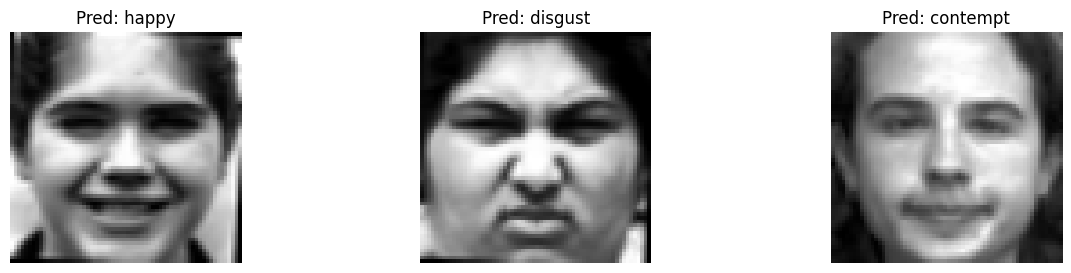

In [10]:
def predict_image(img_path, knn_model, scaler, pca):
    """
    Hàm này nhận đường dẫn đến ảnh, thực hiện tiền xử lý và trích xuất đặc trưng (HOG + DCT),
    sau đó chuẩn hóa và giảm chiều bằng scaler và PCA đã huấn luyện.
    Cuối cùng, mô hình KNN được dùng để dự đoán nhãn của ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        knn_model (estimator): Mô hình KNN đã được huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit trên dữ liệu huấn luyện.
        pca (PCA): Mô hình PCA đã được fit trên dữ liệu huấn luyện.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # Hàm preprocess_image phải được định nghĩa sẵn trong pipeline của bạn
    if processed_img is None:
        raise ValueError("Không đọc được ảnh từ đường dẫn: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 đặc trưng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chuẩn hóa vector đặc trưng theo scaler đã học (với input là một mảng 2 chiều)
    combined_scaled = scaler.transform([combined])
    # Giảm chiều vector đặc trưng sử dụng PCA đã học
    combined_pca = pca.transform(combined_scaled)
    predicted = knn_model.predict(combined_pca)
    return predicted[0], processed_img

# Danh sách đường dẫn ảnh cần dự đoán ví dụ:
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_knn, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM

## SVM Code Hàm

Số thành phần được chọn: 292
Tỷ lệ phương sai giải thích: 0.9503447711801198


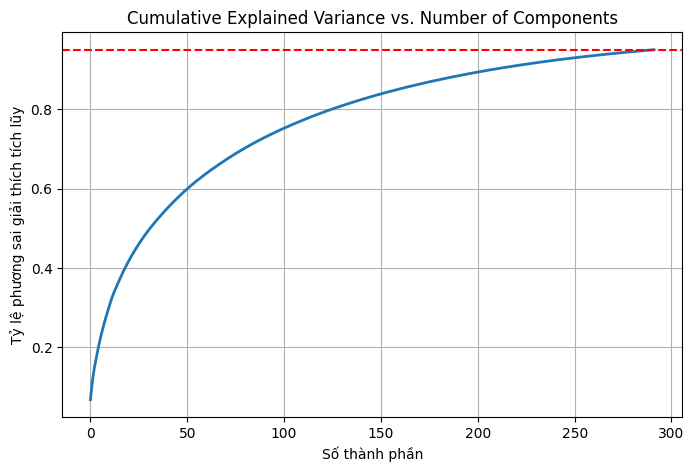

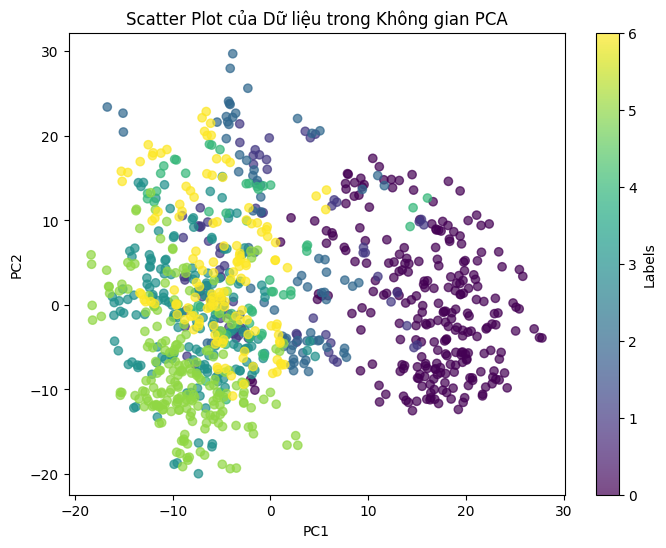

Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9744977951984322

Epoch 1/5
Train Accuracy: 1.0
Test Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       1.00      1.00      1.00        21
     sadness       1.00      1.00      1.00        18
     disgust       1.00      1.00      1.00        37
    contempt       1.00      1.00      1.00        14
       happy       1.00      1.00      1.00        42
       anger       1.00      1.00      1.00        23

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197

--------------------------------------------------
Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9859464314878327

Epoch 2/5
Train Accuracy: 1.0
Test Accurac

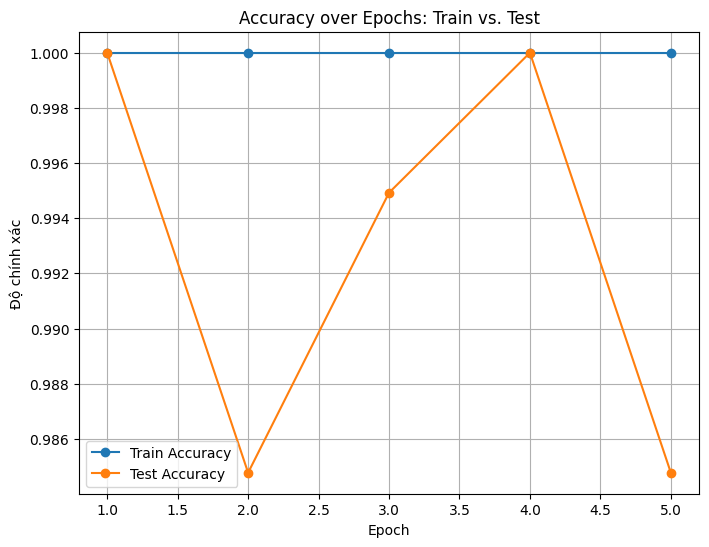

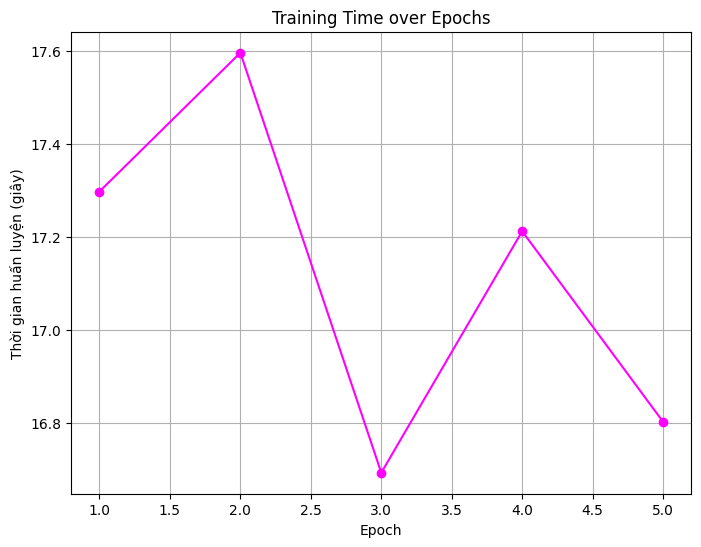

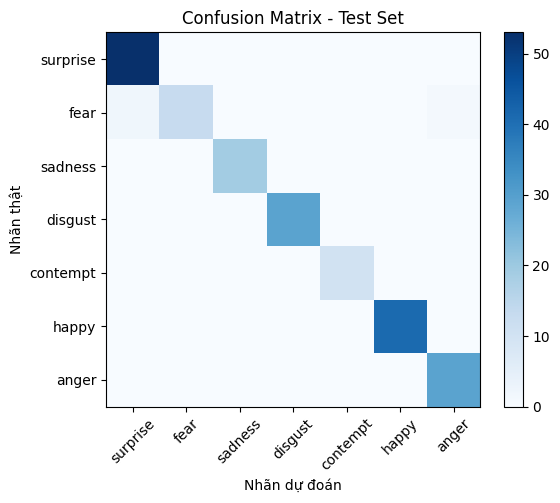

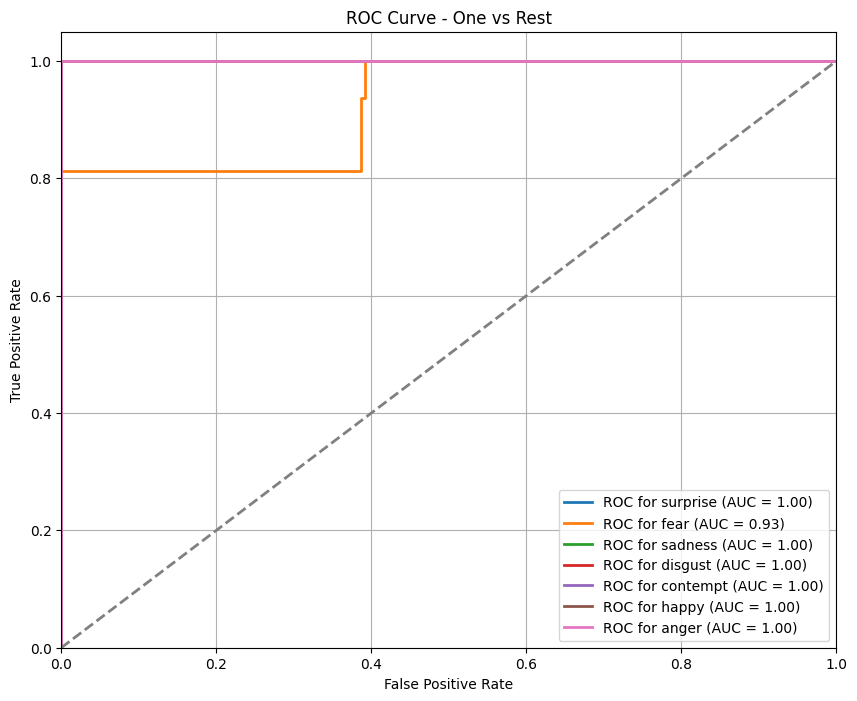

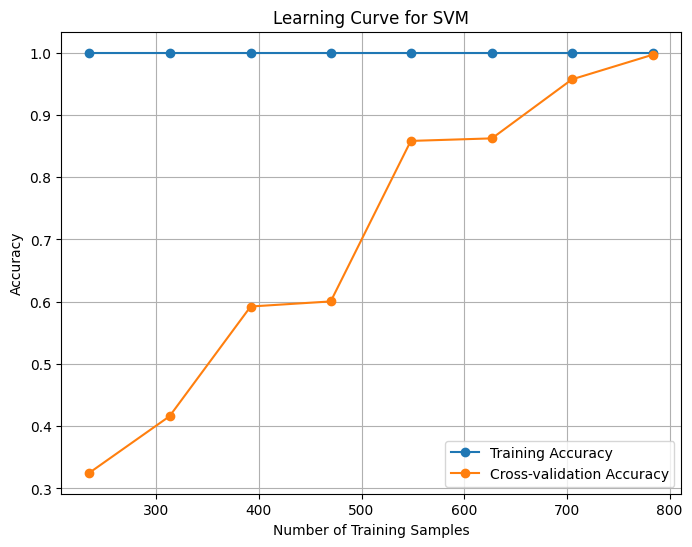

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Giả sử:
#   combined_features: ma trận đặc trưng ban đầu (numpy.ndarray)
#   labels: vector nhãn tương ứng (numpy.ndarray)
#   CATEGORIES: danh sách tên các lớp (ví dụ: ['Class1', 'Class2', 'Class3', ...])
# Lưu ý: CATEGORIES phải khớp với các giá trị nhãn (0,1,2,...)

#############################################
# 1. Giảm chiều dữ liệu với PCA & Biểu đồ Cumulative Explained Variance
#############################################
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Chuẩn hóa và giảm chiều vector đặc trưng bằng StandardScaler và PCA.
    Tự động giữ lại đủ số thành phần để tổng tỷ lệ phương sai giải thích đạt ngưỡng.
    
    Parameters:
       features (np.ndarray): Ma trận đặc trưng ban đầu.
       variance_threshold (float): Ngưỡng tỷ lệ phương sai giải thích (ví dụ 0.95).
       
    Returns:
       features_pca (np.ndarray): Ma trận đặc trưng sau PCA.
       pca (PCA object): Mô hình PCA đã fit.
       scaler (StandardScaler): Bộ chuẩn hóa đã fit.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    
    return features_pca, pca, scaler

# Giảm chiều dữ liệu (ở đây giữ lại 95% phương sai giải thích)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.95)

#############################################
# 2. Scatter Plot của dữ liệu trong không gian PCA
#############################################
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot của Dữ liệu trong Không gian PCA")
plt.colorbar(label="Labels")
plt.show()

#############################################
# 3. Huấn luyện SVM bằng GridSearchCV qua các epoch
#############################################
def grid_search_svm(X_train, y_train):
    """
    Tìm các siêu tham số tối ưu cho SVM bằng GridSearchCV.
    
    Parameters:
       X_train (np.ndarray): Ma trận đặc trưng huấn luyện.
       y_train (np.ndarray): Nhãn huấn luyện.
       
    Returns:
       best_svm (estimator): Mô hình SVM với siêu tham số tối ưu.
       grid (GridSearchCV object): Đối tượng grid search đã được fit.
    """
    # Chú ý: Để thuận tiện tính ROC sau này, ta kích hoạt probability=True.
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }
    
    svm = SVC(random_state=42, probability=True)  # probability=True để tính ROC
    grid = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print("Best parameters:", grid.best_params_)
    print("Best cross-validation accuracy:", grid.best_score_)
    best_svm = grid.best_estimator_
    return best_svm, grid

# Số epoch (ở đây sử dụng 5 epoch ví dụ)
epochs = 5

train_accuracies = []
test_accuracies = []
training_times = []

for epoch in range(epochs):
    start_time = time.time()
    # Thay đổi random_state theo epoch để có được phân chia dữ liệu khác nhau
    X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42 + epoch)
    
    best_svm, grid = grid_search_svm(X_train, y_train)
    
    # Tính độ chính xác trên tập huấn luyện và tập test
    train_acc = accuracy_score(y_train, best_svm.predict(X_train))
    test_acc = accuracy_score(y_test, best_svm.predict(X_test))
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    training_times.append(elapsed_time)
    
    print(f"\nEpoch {epoch+1}/{epochs}")
    print("Train Accuracy:", train_acc)
    print("Test Accuracy:", test_acc)
    print("Classification Report:")
    print(classification_report(y_test, best_svm.predict(X_test), target_names=CATEGORIES))
    print("-"*50)

#############################################
# 4. Biểu đồ Accuracy theo Epoch (Train vs. Test)
#############################################
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, epochs+1), train_accuracies, marker='o', linestyle='-', label="Train Accuracy")
plt.plot(np.arange(1, epochs+1), test_accuracies, marker='o', linestyle='-', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Độ chính xác")
plt.title("Accuracy over Epochs: Train vs. Test")
plt.legend()
plt.grid(True)
plt.show()

#############################################
# 5. Biểu đồ Thời gian Huấn luyện qua các Epoch
#############################################
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, epochs+1), training_times, marker='o', linestyle='-', color='magenta')
plt.xlabel("Epoch")
plt.ylabel("Thời gian huấn luyện (giây)")
plt.title("Training Time over Epochs")
plt.grid(True)
plt.show()

#############################################
# 6. Confusion Matrix cho tập Test (từ epoch cuối cùng)
#############################################
cm = confusion_matrix(y_test, best_svm.predict(X_test))
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(CATEGORIES))
plt.xticks(tick_marks, CATEGORIES, rotation=45)
plt.yticks(tick_marks, CATEGORIES)
plt.ylabel("Nhãn thật")
plt.xlabel("Nhãn dự đoán")
plt.tight_layout()
plt.show()

#############################################
# 7. ROC Curve theo One-vs-Rest cho tập Test
#############################################
# Chuyển đổi nhãn của tập test thành dạng nhị phân.
# Giả sử các lớp được đánh số từ 0 đến len(CATEGORIES)-1.
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# Sử dụng decision_function của SVC để lấy điểm (scores)
y_score = best_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#############################################
# 8. Learning Curve: Sự ảnh hưởng của kích thước tập huấn luyện đến Accuracy
#############################################
train_sizes, train_scores, cv_scores = learning_curve(best_svm, features_pca, labels, cv=5,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
cv_scores_mean = np.mean(cv_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(train_sizes, cv_scores_mean, marker='o', linestyle='-', label="Cross-validation Accuracy")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM")
plt.legend(loc="best")
plt.grid(True)
plt.show()


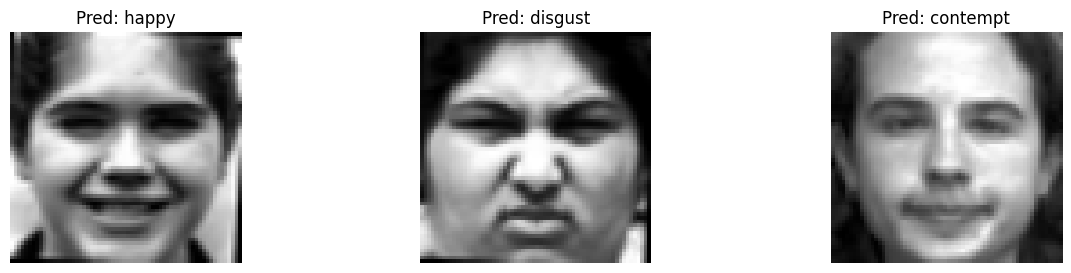

In [12]:
def predict_image(img_path, svm_model, scaler, pca):
    """
    Hàm này nhận đường dẫn đến ảnh, thực hiện tiền xử lý và trích xuất đặc trưng (HOG + DCT),
    sau đó chuẩn hóa và giảm chiều bằng scaler và PCA đã huấn luyện.
    Cuối cùng, mô hình KNN được dùng để dự đoán nhãn của ảnh.

    Parameters:
        img_path (str): Đường dẫn đến ảnh.
        knn_model (estimator): Mô hình KNN đã được huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit trên dữ liệu huấn luyện.
        pca (PCA): Mô hình PCA đã được fit trên dữ liệu huấn luyện.

    Returns:
        tuple: (predicted_label, processed_img)
    """
    processed_img = preprocess_image(img_path)  # Hàm preprocess_image phải được định nghĩa sẵn trong pipeline của bạn
    if processed_img is None:
        raise ValueError("Không đọc được ảnh từ đường dẫn: " + img_path)
    
    hog_feat = extract_hog_features(processed_img)
    dct_feat = extract_dct_features(processed_img, keep_coeffs=8)  # 8x8 = 64 đặc trưng
    combined = np.concatenate((hog_feat, dct_feat))
    
    # Chuẩn hóa vector đặc trưng theo scaler đã học (với input là một mảng 2 chiều)
    combined_scaled = scaler.transform([combined])
    # Giảm chiều vector đặc trưng sử dụng PCA đã học
    combined_pca = pca.transform(combined_scaled)
    predicted = svm_model.predict(combined_pca)
    return predicted[0], processed_img

test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, img_path in zip(axes, test_image_paths):
    pred_label, img = predict_image(img_path, best_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Pred: " + CATEGORIES[pred_label])
    ax.axis('off')

plt.show()

## SVM Code Tay

Số thành phần được chọn: 208
Tỷ lệ phương sai giải thích: 0.9000637563180738


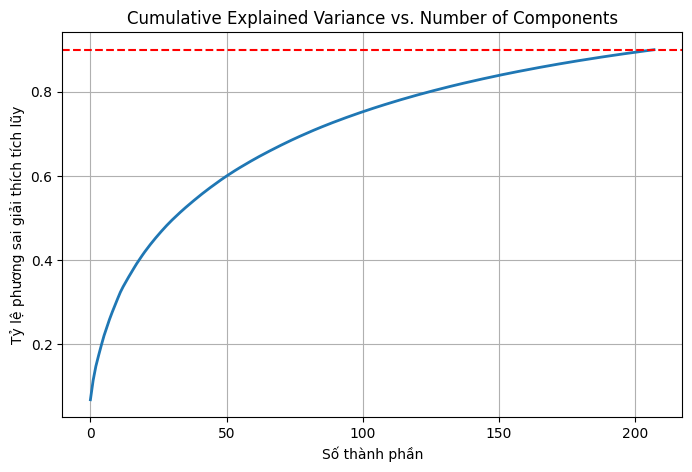

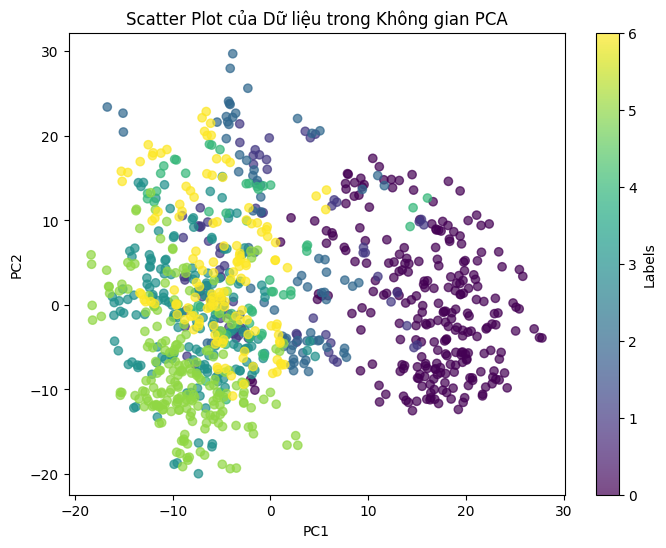

Epoch 10/100, Training Accuracy: 1.0000
Epoch 10/100, Validation Accuracy: 0.9848
Epoch 20/100, Training Accuracy: 0.9987
Epoch 20/100, Validation Accuracy: 0.9898
Epoch 30/100, Training Accuracy: 1.0000
Epoch 30/100, Validation Accuracy: 0.9898
Epoch 40/100, Training Accuracy: 1.0000
Epoch 40/100, Validation Accuracy: 0.9949
Epoch 50/100, Training Accuracy: 1.0000
Epoch 50/100, Validation Accuracy: 0.9949
Epoch 60/100, Training Accuracy: 1.0000
Epoch 60/100, Validation Accuracy: 0.9949
Epoch 70/100, Training Accuracy: 1.0000
Epoch 70/100, Validation Accuracy: 0.9949
Epoch 80/100, Training Accuracy: 1.0000
Epoch 80/100, Validation Accuracy: 0.9949
Epoch 90/100, Training Accuracy: 1.0000
Epoch 90/100, Validation Accuracy: 0.9898
Epoch 100/100, Training Accuracy: 1.0000
Epoch 100/100, Validation Accuracy: 0.9898
Manual SVM Accuracy: 0.9898477157360406
              precision    recall  f1-score   support

    surprise       1.00      1.00      1.00        42
        fear       0.95      

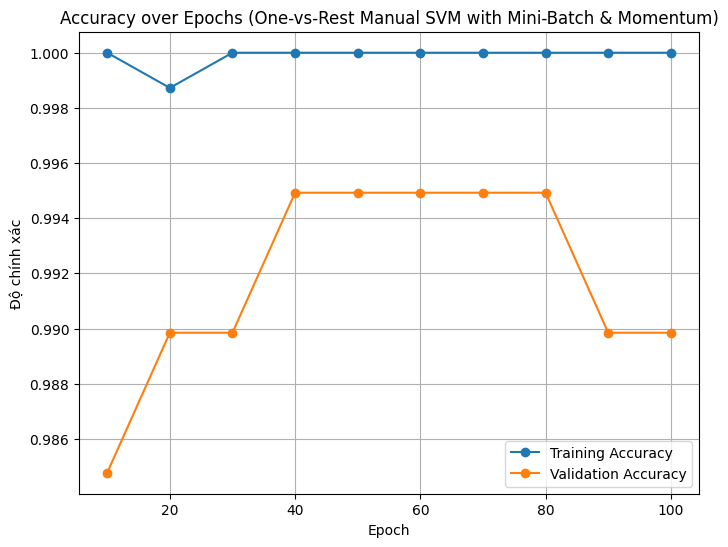

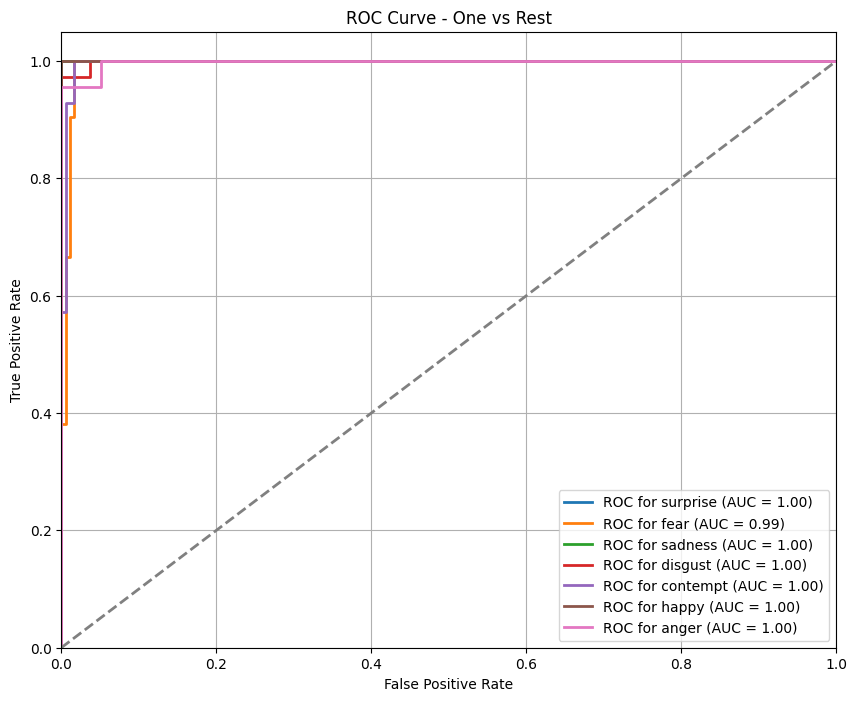

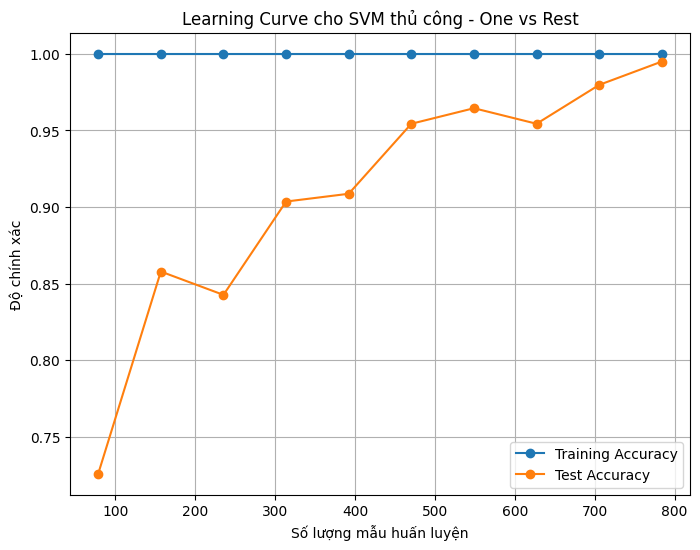

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Giả sử:
#   combined_features: ma trận đặc trưng ban đầu (numpy.ndarray)
#   labels: vector nhãn tương ứng (numpy.ndarray)
#   CATEGORIES: danh sách tên các lớp (ví dụ: ['Class1', 'Class2', 'Class3'])

### 1. Hàm giảm chiều với PCA và trực quan hóa Cumulative Explained Variance
def reduce_dimensionality(features, variance_threshold=0.95):
    """
    Hàm này chuẩn hóa dữ liệu, thực hiện PCA và vẽ biểu đồ tỷ lệ phương sai tích lũy.
    """
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    
    pca = PCA(n_components=variance_threshold)
    features_pca = pca.fit_transform(scaled_features)
    
    print("Số thành phần được chọn:", pca.n_components_)
    print("Tỷ lệ phương sai giải thích:", np.sum(pca.explained_variance_ratio_))
    
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(8, 5))
    plt.plot(cumulative_variance, linewidth=2)
    plt.xlabel("Số thành phần")
    plt.ylabel("Tỷ lệ phương sai giải thích tích lũy")
    plt.title("Cumulative Explained Variance vs. Number of Components")
    plt.grid(True)
    plt.axhline(y=variance_threshold, color='r', linestyle='--')
    plt.show()
    
    return features_pca, pca, scaler

# Giảm chiều dữ liệu (đặt threshold=0.9 để giữ 90% phương sai giải thích)
features_pca, pca_model, scaler = reduce_dimensionality(combined_features, variance_threshold=0.9)

### 2. Biểu đồ Scatter của dữ liệu trong không gian PCA (toàn bộ dữ liệu)
plt.figure(figsize=(8,6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter Plot của Dữ liệu trong Không gian PCA")
plt.colorbar(label="Labels")
plt.show()

### 3. Định nghĩa mô hình One-vs-Rest SVM "thủ công" sử dụng Mini-Batch Gradient Descent kết hợp với Momentum
class OneVsRestSVM:
    """
    Cài đặt SVM theo chiến lược One-vs-Rest sử dụng mini-batch gradient descent kết hợp với momentum cho hàm mất mát hinge.

    Hàm mất mát (loss) đối với một bộ phân lớp nhị phân được định nghĩa là:
    
        L(w, b) = (lambda_reg/2) * ||w||^2 + sum_{i=1}^{N} max(0, 1 - y_i*(w^T x_i + b))
    
    Trong đó:
      - lambda_reg: Hệ số regularization (điều chỉnh độ phạt của norm w).
      - ||w||^2: Bình phương chuẩn L2 của vector trọng số.
      - max(0, 1 - y_i*(w^T x_i + b)) là hàm hinge loss với y_i ∈ {+1, -1}.
    
    Công thức gradient của hàm mất mát đối với mỗi mẫu:
      Nếu margin = 1 - y_i * (w^T x_i + b) > 0, thì:
          grad_w_i = - y_i * x_i   và  grad_b_i = - y_i
      Nếu margin <= 0, thì:
          grad_w_i = 0 và grad_b_i = 0
          
    Sau đó, tổng gradient trên mini-batch với regularization:
          grad_w = lambda_reg * w - sum_{i where margin > 0} (y_i * x_i)
          grad_b = - sum_{i where margin > 0} (y_i)
    
    Mini-Batch Gradient Descent:
      - Chia tập huấn luyện thành các mini-batch có kích thước batch_size.
      - Tính gradient trên mỗi mini-batch và cập nhật trọng số.
    
    Momentum:
      - Sử dụng vận tốc (velocity) để lưu trữ sự thay đổi của trọng số, cập nhật theo công thức:
            v = momentum * v - learning_rate * gradient
        Sau đó, cập nhật trọng số:
            w = w + v
    """
    def __init__(self, learning_rate=0.001, n_epochs=100, lambda_reg=0.01, batch_size=32, momentum=0.9):
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.lambda_reg = lambda_reg
        self.batch_size = batch_size
        self.momentum = momentum
        self.classes_ = None
        self.W = {}  # Lưu trọng số (w) và bias (b) cho mỗi lớp.
        self.V = {}  # Lưu vận tốc (velocity) cho cập nhật momentum của từng lớp.

    def fit(self, X, y, X_val=None, y_val=None, track_history=False, history_step=10):
        """
        Huấn luyện mô hình sử dụng mini-batch gradient descent kết hợp với momentum.

        Parameters:
            X (np.ndarray): Dữ liệu huấn luyện.
            y (np.ndarray): Nhãn huấn luyện.
            X_val (np.ndarray): Dữ liệu kiểm tra (tuỳ chọn) để theo dõi accuracy qua các epoch.
            y_val (np.ndarray): Nhãn của dữ liệu kiểm tra.
            track_history (bool): Nếu True, theo dõi accuracy qua epoch.
            history_step (int): Mỗi bao nhiêu epoch tính accuracy.

        Returns:
            history: dict chứa 'epoch', 'train_acc' và (nếu có) 'val_acc'
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        # Khởi tạo trọng số, bias và velocity cho từng lớp.
        for c in self.classes_:
            self.W[c] = (np.zeros(n_features), 0)     # w và b khởi tạo bằng 0
            self.V[c] = (np.zeros(n_features), 0)       # velocity cho w và b khởi tạo bằng 0
        
        history = {'epoch': [], 'train_acc': []}
        if X_val is not None and y_val is not None:
            history['val_acc'] = []
        
        # Huấn luyện theo epoch:
        for epoch in range(1, self.n_epochs + 1):
            # Trộn ngẫu nhiên dữ liệu huấn luyện để tạo các mini-batch ngẫu nhiên.
            permutation = np.random.permutation(n_samples)
            X_shuffled = X[permutation]
            y_shuffled = y[permutation]
            
            # Duyệt qua từng mini-batch
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i:i + self.batch_size]
                y_batch = y_shuffled[i:i + self.batch_size]
                
                # Cập nhật cho từng lớp
                for c in self.classes_:
                    # Chuyển đổi nhãn trong mini-batch về dạng nhị phân: +1 nếu thuộc lớp c, -1 nếu không.
                    y_binary = np.where(y_batch == c, 1, -1)
                    
                    # Lấy trọng số và bias hiện tại của lớp c.
                    w, b = self.W[c]
                    
                    # Tính margin cho các mẫu trong mini-batch:
                    # margin = 1 - y_i * (w^T x_i + b)
                    margins = 1 - y_binary * (np.dot(X_batch, w) + b)
                    
                    # Xác định các mẫu vi phạm margin (margin > 0)
                    idx = margins > 0
                    
                    # Tính gradient dựa trên các công thức:
                    # grad_w = lambda_reg * w - sum_{i in mini-batch and margin > 0} (y_i * x_i)
                    # grad_b = - sum_{i in mini-batch and margin > 0} (y_i)
                    if np.sum(idx) > 0:
                        grad_w = self.lambda_reg * w - np.dot(X_batch[idx].T, y_binary[idx])
                        grad_b = -np.sum(y_binary[idx])
                    else:
                        grad_w = self.lambda_reg * w
                        grad_b = 0
                    
                    # Lấy velocity hiện tại cho lớp c
                    v_w, v_b = self.V[c]
                    
                    # Cập nhật velocity theo công thức momentum:
                    # v = momentum * v - learning_rate * gradient
                    v_w = self.momentum * v_w - self.learning_rate * grad_w
                    v_b = self.momentum * v_b - self.learning_rate * grad_b
                    
                    # Cập nhật trọng số và bias bằng cách cộng velocity:
                    # w = w + v, b = b + v_b
                    w = w + v_w
                    b = b + v_b
                    
                    # Lưu lại trọng số, bias và velocity đã cập nhật cho lớp c.
                    self.W[c] = (w, b)
                    self.V[c] = (v_w, v_b)
            
            # Theo dõi và lưu lại accuracy sau mỗi history_step epoch.
            if track_history and epoch % history_step == 0:
                y_pred_train = self.predict(X)
                train_acc = accuracy_score(y, y_pred_train)
                history['epoch'].append(epoch)
                history['train_acc'].append(train_acc)
                print(f"Epoch {epoch}/{self.n_epochs}, Training Accuracy: {train_acc:.4f}")
                if X_val is not None and y_val is not None:
                    y_pred_val = self.predict(X_val)
                    val_acc = accuracy_score(y_val, y_pred_val)
                    history['val_acc'].append(val_acc)
                    print(f"Epoch {epoch}/{self.n_epochs}, Validation Accuracy: {val_acc:.4f}")
                    
        return history

    def decision_function(self, X):
        """
        Tính điểm (score) cho mỗi lớp cho tập dữ liệu X.
        Dùng để xác định nhãn dự đoán và trực quan ROC Curve.
        """
        n_samples = X.shape[0]
        scores = np.zeros((n_samples, len(self.classes_)))  # ma trận score (n_samples x số lớp)
        for i, c in enumerate(self.classes_):
            w, b = self.W[c]
            scores[:, i] = np.dot(X, w) + b
        return scores

    def predict(self, X):
        """
        Dự đoán nhãn cho các mẫu trong X bằng cách chọn lớp có điểm số cao nhất.
        """
        scores = self.decision_function(X)
        predictions = np.argmax(scores, axis=1)
        return predictions

### 4. Chia dữ liệu và huấn luyện mô hình với tracking qua epoch (sử dụng n_epochs từ 5 đến 100)
X_train, X_test, y_train, y_test = train_test_split(features_pca, labels, test_size=0.2, random_state=42)

# Sử dụng 100 epoch (có thể điều chỉnh trong khoảng từ 5 đến 100)
n_epochs = 100  
manual_svm = OneVsRestSVM(learning_rate=0.0005, n_epochs=n_epochs, lambda_reg=0.01, batch_size=32, momentum=0.9)
history = manual_svm.fit(X_train, y_train, X_val=X_test, y_val=y_test, track_history=True, history_step=10)

y_pred_manual = manual_svm.predict(X_test)
acc_manual = accuracy_score(y_test, y_pred_manual)
print("Manual SVM Accuracy:", acc_manual)
print(classification_report(y_test, y_pred_manual, target_names=CATEGORIES))

### 5. Vẽ đường chạy Accuracy theo Epoch
plt.figure(figsize=(8,6))
plt.plot(history['epoch'], history['train_acc'], marker='o', linestyle='-', label="Training Accuracy")
if 'val_acc' in history:
    plt.plot(history['epoch'], history['val_acc'], marker='o', linestyle='-', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Độ chính xác")
plt.title("Accuracy over Epochs (One-vs-Rest Manual SVM with Mini-Batch & Momentum)")
plt.legend()
plt.grid(True)
plt.show()


### 7. ROC Curve theo One-vs-Rest
n_classes = len(CATEGORIES)
y_test_bin = label_binarize(y_test, classes=manual_svm.classes_)
y_score = manual_svm.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC for {CATEGORIES[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### 8. Learning Curve: Ảnh hưởng của kích thước tập huấn luyện đến Accuracy
fractions = np.linspace(0.1, 1.0, 10)
train_accs = []
test_accs = []

for frac in fractions:
    idx = np.random.choice(len(X_train), int(frac * len(X_train)), replace=False)
    X_train_subset = X_train[idx]
    y_train_subset = y_train[idx]
    
    temp_svm = OneVsRestSVM(learning_rate=0.0005, n_epochs=n_epochs, lambda_reg=0.01, batch_size=32, momentum=0.9)
    temp_svm.fit(X_train_subset, y_train_subset)
    
    train_acc = accuracy_score(y_train_subset, temp_svm.predict(X_train_subset))
    test_acc = accuracy_score(y_test, temp_svm.predict(X_test))
    train_accs.append(train_acc)
    test_accs.append(test_acc)

plt.figure(figsize=(8,6))
plt.plot(fractions * len(X_train), train_accs, marker='o', linestyle='-', label="Training Accuracy")
plt.plot(fractions * len(X_train), test_accs, marker='o', linestyle='-', label="Test Accuracy")
plt.xlabel("Số lượng mẫu huấn luyện")
plt.ylabel("Độ chính xác")
plt.title("Learning Curve cho SVM thủ công - One vs Rest")
plt.legend(loc="best")
plt.grid(True)
plt.show()


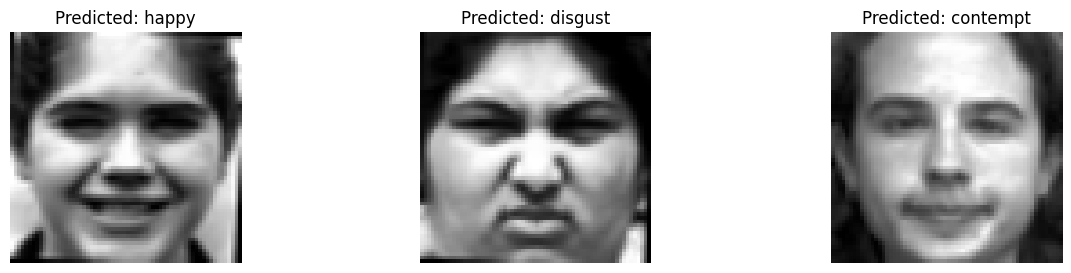

In [14]:

def predict_image(img_path, svm_model, scaler, pca):
    """
    Dự đoán nhãn cho ảnh mới:
      - Tiền xử lý ảnh.
      - Trích xuất đặc trưng HOG và DCT, sau đó kết hợp chúng.
      - Chuẩn hóa và giảm chiều bằng scaler và pca đã học.
      - Dự đoán nhãn bằng mô hình SVM tay.
      
    Parameters:
        img_path (str): Đường dẫn ảnh.
        svm_model (OneVsRestSVM): Mô hình SVM tay đã huấn luyện.
        scaler (StandardScaler): Đối tượng scaler đã fit.
        pca (PCA): Mô hình PCA đã fit.
        
    Returns:
        tuple: (predicted_label, processed_img)
    """
    proc_img = preprocess_image(img_path)
    if proc_img is None:
        raise ValueError("Không đọc được ảnh từ: " + img_path)
    
    hog_feat = extract_hog_features(proc_img)
    dct_feat = extract_dct_features(proc_img, keep_coeffs=8)
    combined = np.concatenate((hog_feat, dct_feat))
    
    combined_scaled = scaler.transform([combined])
    combined_pca = pca.transform(combined_scaled)
    
    pred = svm_model.predict(combined_pca)
    return pred[0], proc_img

# Danh sách đường dẫn ảnh mới để dự đoán
test_image_paths = [
    '/kaggle/input/ck-dataset/happy/S011_006_00000011.png',
    '/kaggle/input/ck-dataset/disgust/S005_001_00000009.png',
    '/kaggle/input/ck-dataset/contempt/S151_002_00000029.png'
]

fig, axes = plt.subplots(1, len(test_image_paths), figsize=(15, 3))
for ax, path in zip(axes, test_image_paths):
    pred_label, img = predict_image(path, manual_svm, scaler, pca_model)
    ax.imshow(img, cmap='gray')
    ax.set_title("Predicted: " + CATEGORIES[pred_label])
    ax.axis('off')
plt.show()


In [15]:
----

SyntaxError: invalid syntax (2133496677.py, line 1)

## Code Deep Learning

In [ ]:
# %% 00.1 — Downgrade TensorFlow
!pip uninstall -y tensorflow tensorflow-gpu
!pip install tensorflow==2.14.0



In [16]:
import os, cv2, random, time, numpy as np
from pathlib import Path
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, mixed_precision
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPU detected →", gpus[0].name)
    mixed_precision.set_global_policy("mixed_float16")   # FP16 maths
    tf.config.optimizer.set_jit(True)                    # XLA compile
else:
    print("No GPU detected, running on CPU.")

SEED      = 42
IMG_SIZE  = 48
DICT_SIZE = 2048
EPOCHS    = 20
BATCH     = 256 if gpus else 128      # GPU -> batch lớn hơn
DATA_DIR  = "/kaggle/input/ck-dataset"    
SAVE_DIR  = "/kaggle/working/models"
TRAIN_MODE= "dsift"                     # "cnn" | "sift" | "dsift"
os.makedirs(SAVE_DIR, exist_ok=True)

np.random.seed(SEED); tf.random.set_seed(SEED)

No GPU detected, running on CPU.


2025-05-19 18:18:31.375259: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [17]:
def load_ckplus(root):
    emos = ["anger","contempt","disgust","fear","happy","sadness","surprise"]
    label = {e:i for i,e in enumerate(emos)}
    X, y = [], []
    print("Loading dataset …")
    for e in emos:
        files = [*Path(root, e).rglob("*.png"), *Path(root, e).rglob("*.jpg")]
        for p in tqdm(files, desc=f"  ↳ {e:9}", unit="img"):
            im = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
            if im is None: continue
            im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
            X.append(im); y.append(label[e])
    X = np.array(X, dtype="uint8"); y = np.array(y, dtype="int32")
    print(f"{X.shape[0]} images loaded.")
    return X, y

X_raw, y_raw = load_ckplus(DATA_DIR)

Loading dataset …


  ↳ anger    :   0%|          | 0/135 [00:00<?, ?img/s]

  ↳ contempt :   0%|          | 0/54 [00:00<?, ?img/s]

  ↳ disgust  :   0%|          | 0/177 [00:00<?, ?img/s]

  ↳ fear     :   0%|          | 0/75 [00:00<?, ?img/s]

  ↳ happy    :   0%|          | 0/207 [00:00<?, ?img/s]

  ↳ sadness  :   0%|          | 0/84 [00:00<?, ?img/s]

  ↳ surprise :   0%|          | 0/249 [00:00<?, ?img/s]

981 images loaded.


In [18]:
def augment(img):
    h,w = img.shape; res=[]
    res.append(cv2.flip(img,1))
    angle=random.uniform(-30,30)
    M=cv2.getRotationMatrix2D((w/2,h/2),angle,1)
    res.append(cv2.warpAffine(img,M,(w,h)))
    for dx,dy in [(0,0),(8,0),(0,8),(8,8)]:
        crop=img[dy:dy+40, dx:dx+40]
        res.append(cv2.resize(crop,(w,h)))
    pts1=np.float32([[14,14],[34,14],[14,34]])
    pts2=np.float32([[12,16],[36,12],[16,36]])
    M=cv2.getAffineTransform(pts1,pts2)
    res.append(cv2.warpAffine(img,M,(w,h)))
    return res

print(" Augmenting …")
Xa, ya = [], []
for im,lbl in tqdm(zip(X_raw,y_raw), total=len(X_raw)):
    Xa.append(im); ya.append(lbl)
    for a in augment(im): Xa.append(a); ya.append(lbl)
Xa = (np.array(Xa, dtype="float32")[...,None])/255.0
ya = np.array(ya, dtype="int32")
print(" After aug:", Xa.shape)

 Augmenting …


  0%|          | 0/981 [00:00<?, ?it/s]

 After aug: (7848, 48, 48, 1)


In [19]:
sift = cv2.SIFT_create()

def dsift(gray):
    step=12
    kps=[cv2.KeyPoint(x,y,12) for y in range(0,IMG_SIZE,step)
                                 for x in range(0,IMG_SIZE,step)]
    _,d=sift.compute((gray*255).astype("uint8"), kps)
    return d

def rsift(gray):
    kps=sift.detect((gray*255).astype("uint8"), None)
    _,d=sift.compute((gray*255).astype("uint8"), kps)
    return d

def fit_km(fn, sample):
    buf=[]
    print("Collecting descriptors …")
    for im in tqdm(sample, unit="img"):
        d=fn(im[...,0]);  buf.append(d) if d is not None else None
        if len(buf)>500: break
    mat=np.vstack(buf)
    print("Fitting K-means …")
    km=MiniBatchKMeans(DICT_SIZE, random_state=SEED,
                       batch_size=2048).fit(mat)
    return km

km_sift  = fit_km(rsift , Xa[:1000])
km_dsift = fit_km(dsift, Xa[:1000])

def bow(km, desc):
    if desc is None: return np.zeros(DICT_SIZE, "float32")
    h=np.bincount(km.predict(desc), minlength=DICT_SIZE).astype("float32")
    return h/(h.sum()+1e-6)

def bow_feats(imgs, km, fn, title):
    feats=[]
    print(f"🛠  Building BoW − {title} …")
    for im in tqdm(imgs, unit="img"):
        feats.append(bow(km, fn(im[...,0])))
    return np.stack(feats)

X_bow_s = bow_feats(Xa, km_sift , rsift , "SIFT")
X_bow_d = bow_feats(Xa, km_dsift, dsift, "Dense-SIFT")
sc_s, sc_d = StandardScaler().fit(X_bow_s), StandardScaler().fit(X_bow_d)
X_bow_s, X_bow_d = sc_s.transform(X_bow_s), sc_d.transform(X_bow_d)

  0%|          | 0/1000 [00:00<?, ?img/s]

Fitting K-means …


  0%|          | 0/1000 [00:00<?, ?img/s]

Fitting K-means …
🛠  Building BoW − SIFT …


  0%|          | 0/7848 [00:00<?, ?img/s]

🛠  Building BoW − Dense-SIFT …


  0%|          | 0/7848 [00:00<?, ?img/s]

In [20]:
# Train / val split
idx=np.arange(len(Xa)); np.random.shuffle(idx)
tr,va = idx[:int(.8*len(idx))], idx[int(.8*len(idx)):]
def sp(arr): return arr[tr], arr[va]
X_c_tr,X_c_va   = sp(Xa)
Xs_tr,Xs_va     = sp(X_bow_s)
Xd_tr,Xd_va     = sp(X_bow_d)
y_tr,y_va       = ya[tr], ya[va]
print(f"Train: {len(tr)}  |  Val: {len(va)}")

Train: 6278  |  Val: 1570


In [21]:
 # CNN branch (6 conv + 2 FC)
def make_cnn():
    i = layers.Input((IMG_SIZE, IMG_SIZE, 1))
    def block(x,f):
        x=layers.Conv2D(f,3,padding="same",activation="relu")(x)
        x=layers.Conv2D(f,3,padding="same",activation="relu")(x)
        x=layers.MaxPooling2D()(x); x=layers.Dropout(.25)(x); return x
    x=block(i,64); x=block(x,128); x=block(x,256)
    x=layers.Flatten()(x)
    x=layers.Dense(2048,activation="relu")(x)
    x=layers.Dropout(.5)(x)
    # softmax phải float32 khi mixed precision
    o = layers.Dense(7, activation="softmax", dtype="float32")(x)
    m = models.Model(i, o, name="CNN")
    m.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]      # ← đặt rõ tên
    )
    return m

In [22]:
# Hybrid CNN + BoW-SIFT
def make_hybrid(tag):
    cnn = make_cnn()
    i_bow=layers.Input((DICT_SIZE,))
    b=layers.Dense(4096,activation="relu",
        kernel_regularizer=regularizers.l2(.01))(i_bow)
    b=layers.Dropout(.5)(b)
    merge=layers.Concatenate()([cnn.layers[-3].output,b])
    o = layers.Dense(7, activation="softmax", dtype="float32")(merge)
    m = models.Model([cnn.input, i_bow], o, name=f"Hybrid_{tag}")
    m.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return m

In [23]:
if TRAIN_MODE=="cnn":
    print(" Train CNN …")
    model=make_cnn()
    model.fit(X_c_tr,y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=(X_c_va,y_va))
    model.save(f"{SAVE_DIR}/cnn.h5")
elif TRAIN_MODE=="sift":
    print(" Train CNN+SIFT …")
    model=make_hybrid("SIFT")
    model.fit([X_c_tr,Xs_tr],y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=([X_c_va,Xs_va],y_va))
    model.save(f"{SAVE_DIR}/sift.h5")
elif TRAIN_MODE=="dsift":
    print(" Train CNN+Dense-SIFT …")
    model=make_hybrid("DSIFT")
    model.fit([X_c_tr,Xd_tr],y_tr,epochs=EPOCHS,batch_size=BATCH,
              validation_data=([X_c_va,Xd_va],y_va))
    model.save(f"{SAVE_DIR}/dsift.h5")

 Train CNN+Dense-SIFT …
Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - accuracy: 0.3827 - loss: 18.2403 - val_accuracy: 0.5433 - val_loss: 5.9850
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.6293 - loss: 4.8671 - val_accuracy: 0.5707 - val_loss: 3.2037
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.6394 - loss: 2.8206 - val_accuracy: 0.5611 - val_loss: 2.6171
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.6289 - loss: 2.4169 - val_accuracy: 0.5682 - val_loss: 2.4862
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.6284 - loss: 2.3212 - val_accuracy: 0.5580 - val_loss: 2.4823
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.6301 - loss: 2.3068 - val_accuracy: 0.5650 - val_loss: 2.4157
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.6394 - loss: 2.2172 - val_accuracy: 0.5650 - val_loss: 2.3552
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.6400 - loss: 2.1694 -

In [24]:
def webcam_demo():
    cnn  = tf.keras.models.load_model(f"{SAVE_DIR}/cnn.h5")
    sift = tf.keras.models.load_model(f"{SAVE_DIR}/sift.h5")
    ds   = tf.keras.models.load_model(f"{SAVE_DIR}/dsift.h5")
    names=["Anger","Contempt","Disgust","Fear","Happy","Sad","Surprise"]
    face=cv2.CascadeClassifier(cv2.data.haarcascades+"haarcascade_frontalface_default.xml")
    cap=cv2.VideoCapture(0); t0=time.time()
    print("🎥  Webcam on – Esc để thoát")
    while True:
        ok,frm=cap.read();  if not ok: break
        g=cv2.cvtColor(frm,cv2.COLOR_BGR2GRAY)
        for (x,y,w,h) in face.detectMultiScale(g,1.3,5):
            roi=cv2.resize(g[y:y+h,x:x+w],(IMG_SIZE,IMG_SIZE))
            c_in=roi[None,...,None]/255.
            bs=sc_s.transform(bow(km_sift , rsift (roi)).reshape(1,-1))
            bd=sc_d.transform(bow(km_dsift, dsift(roi)).reshape(1,-1))
            p=(cnn (c_in,0)+
               sift([c_in,bs],0)+
               ds  ([c_in,bd],0))/3
            label=names[int(np.argmax(p))]
            cv2.rectangle(frm,(x,y),(x+w,y+h),(0,255,0),2)
            cv2.putText(frm,label,(x,y-10),0,.9,(0,255,0),2)
        fps=1/(time.time()-t0); t0=time.time()
        cv2.putText(frm,f"{fps:.1f} FPS",(10,30),0,.8,(0,255,255),2)
        cv2.imshow("Hybrid CNN-SIFT",frm)
        if cv2.waitKey(1)&0xFF==27: break
    cap.release(); cv2.destroyAllWindows()

# webcam_demo()   # ← bỏ comment khi đã huấn luyện đủ 3 .h5